## EDA for data understanding and visualisations

In [2]:
# Importing the relevant libraries

import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
import warnings
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_NAME

pd.set_option('display.max_columns', None)

RSEED = 42
# Modeling Libraries

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # pip install plotly needs to executed
import plotly.graph_objects as go

In [2]:
# We need to add plotly to our requirements

In [38]:
# Reading in the data 
df = pd.read_csv('../data/Flu_Shot_Data_cleaned_1.csv')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21853 entries, 0 to 21852
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   21853 non-null  int64  
 1   h1n1_vaccine                 21853 non-null  int64  
 2   seasonal_vaccine             21853 non-null  int64  
 3   h1n1_concern                 21853 non-null  float64
 4   h1n1_knowledge               21853 non-null  float64
 5   behavioral_antiviral_meds    21853 non-null  float64
 6   behavioral_avoidance         21853 non-null  float64
 7   behavioral_face_mask         21853 non-null  float64
 8   behavioral_wash_hands        21853 non-null  float64
 9   behavioral_large_gatherings  21853 non-null  float64
 10  behavioral_outside_home      21853 non-null  float64
 11  behavioral_touch_face        21853 non-null  float64
 12  doctor_recc_h1n1             21853 non-null  float64
 13  doctor_recc_seas

In [40]:
# Looking at the distribution of our target variables 

print(df.h1n1_vaccine.value_counts(normalize=True))
print(df.seasonal_vaccine.value_counts(normalize=True))

0    0.773624
1    0.226376
Name: h1n1_vaccine, dtype: float64
0    0.52034
1    0.47966
Name: seasonal_vaccine, dtype: float64


<AxesSubplot:xlabel='h1n1_vaccine', ylabel='count'>

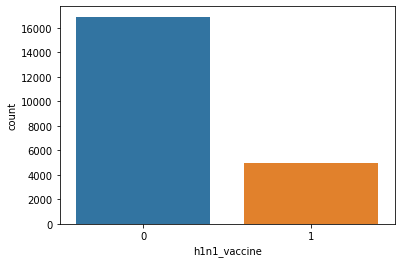

In [41]:
sns.countplot(x='h1n1_vaccine', data=df)

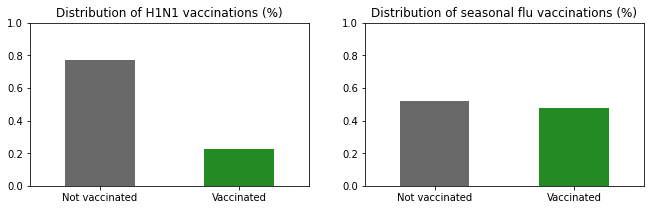

In [42]:
# Creating plots for the distribution of our target variables 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,3))

df['h1n1_vaccine'].value_counts(normalize=True).plot(kind='bar', ax=ax1, color=['dimgrey', 'forestgreen'], rot=0)
ax1.set_title('Distribution of H1N1 vaccinations (%)')
ax1.set_xlabel('')
ax1.set_xticklabels(['Not vaccinated', 'Vaccinated'])
ax1.set_ylim([0,1]) # setting the limits for the y-axis

df['seasonal_vaccine'].value_counts(normalize=True).plot(kind='bar', ax=ax2, color=['dimgrey', 'forestgreen'], rot=0)
ax2.set_title('Distribution of seasonal flu vaccinations (%)')
ax2.set_xlabel('')
ax2.set_xticklabels(['Not vaccinated', 'Vaccinated'])
ax2.set_ylim([0,1]) # setting the limits for the y-axis

fig.subplots_adjust(hspace=0.3)
plt.savefig('../images/distribution_target.jpg')
plt.show()


In [43]:
df.groupby('h1n1_vaccine')['seasonal_vaccine'].value_counts(sort=False)

h1n1_vaccine  seasonal_vaccine
0             0                   10540
              1                    6366
1             0                     831
              1                    4116
Name: seasonal_vaccine, dtype: int64

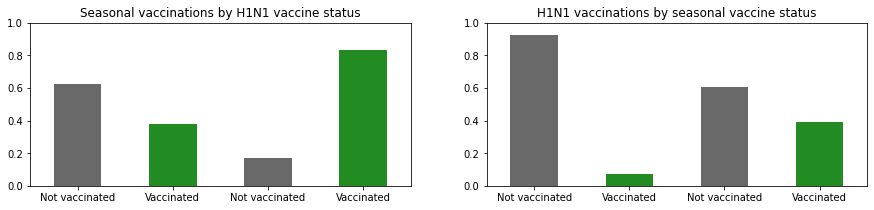

In [44]:
# Creating plots for the distribution of overlaps between H1N1 and seasonal flu vaccines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))

df.groupby('h1n1_vaccine').seasonal_vaccine.value_counts(normalize=True, sort=False).plot(kind='bar', color=['dimgrey', 'forestgreen'], ax=ax1,  rot=0)
ax1.set_title('Seasonal vaccinations by H1N1 vaccine status')
ax1.set_xlabel('')
ax1.set_xticklabels(['Not vaccinated', 'Vaccinated', 'Not vaccinated', 'Vaccinated'])
ax1.set_ylim([0,1])

df.groupby('seasonal_vaccine').h1n1_vaccine.value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax2, color=['dimgrey', 'forestgreen'], rot=0)
ax2.set_title('H1N1 vaccinations by seasonal vaccine status')
ax2.set_xlabel('')
ax2.set_xticklabels(['Not vaccinated', 'Vaccinated', 'Not vaccinated', 'Vaccinated'])
ax2.set_ylim([0,1])

fig.subplots_adjust(hspace=0.3)
plt.savefig('../images/distribution_target_compared.jpg')
plt.show()


- The share of people with seasonal flu vaccination is higher among people that did get an H1N1 vaccine.
- The share of people with H1N1 vaccination is higher among people that also go the seasonal flu vaccine.
- The graphs show that there seems to be a correlation between both types of vaccinations. 

- The graphs are not self explanatory. There needs to be a better indication. 

## Influence of doctor's recommendations 

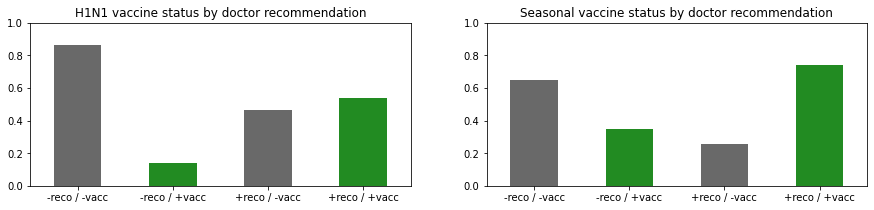

In [45]:
# Creating plots for showing if vaccinations have been recommended by a doctor

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))

df.groupby('doctor_recc_h1n1').h1n1_vaccine.value_counts(normalize=True, sort=False).plot(kind='bar', color=['dimgrey', 'forestgreen'], ax=ax1,  rot=0)
ax1.set_title('H1N1 vaccine status by doctor recommendation')
ax1.set_xlabel('')
ax1.set_xticklabels(['-reco / -vacc', '-reco / +vacc', '+reco / -vacc', '+reco / +vacc'])
ax1.set_ylim([0,1])

df.groupby('doctor_recc_seasonal').seasonal_vaccine.value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax2, color=['dimgrey', 'forestgreen'], rot=0)
ax2.set_title('Seasonal vaccine status by doctor recommendation')
ax2.set_xlabel('')
ax2.set_xticklabels(['-reco / -vacc', '-reco / +vacc', '+reco / -vacc', '+reco / +vacc'])
ax2.set_ylim([0,1])
# ax2.legend(title='color', bbox_to_anchor=(1.05, 1), loc='upper left')

fig.subplots_adjust(hspace=0.3)

plt.savefig('../images/target_recommendations.jpg')
plt.show()


- Recommendations of the respective vaccine are important for getting the vaccine.
- Only a small proportion of people that did not get a recommendation, got the vaccine. 
- For seasonal flu vaccinations, the share of people that did not get a recommendation from a doctor is higher than for H1N1.

- In order to get some of the columns into Categorical mode, they will be changed.
- Otherwise, plots will adapt different strategies for displaying the order of them (sort=False does not work)

In [46]:
df['opinion_h1n1_risk'] = pd.Categorical(df['opinion_h1n1_risk'], ordered=True)
df['opinion_seas_risk'] = pd.Categorical(df['opinion_seas_risk'], ordered=True)

df['h1n1_concern'] = pd.Categorical(df['h1n1_concern'], ordered=True)
df['h1n1_knowledge'] = pd.Categorical(df['h1n1_knowledge'], ordered=True)

### Investigating Vaccinations by risk awareness

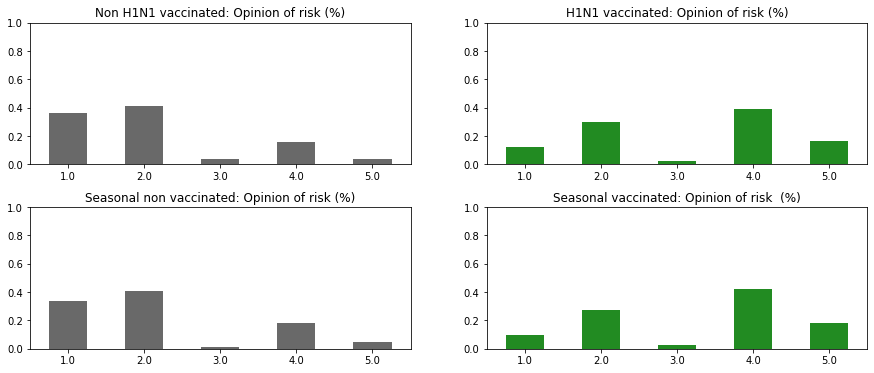

In [47]:
# Splitting the dataset into vaccinated and non vaccinated for each vaccine type
plot_h1n1_no = df.loc[df['h1n1_vaccine']== 0]
plot_h1n1_yes = df.loc[df['h1n1_vaccine']== 1]
plot_seasonal_no = df.loc[df['seasonal_vaccine']== 0]
plot_seasonal_yes = df.loc[df['seasonal_vaccine']== 1]

fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2, 2, figsize=(15,6))

plot_h1n1_no['opinion_h1n1_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax1, rot=0, color='dimgrey')
ax1.set_title('Non H1N1 vaccinated: Opinion of risk (%)')
ax1.set_xlabel('')
ax1.set_ylim([0,1]) # setting the limits for the y-axis

plot_h1n1_yes['opinion_h1n1_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax2, rot=0, color='forestgreen')
ax2.set_title('H1N1 vaccinated: Opinion of risk (%)')
ax2.set_xlabel('')
ax2.set_ylim([0,1]) # setting the limits for the y-axis

plot_seasonal_no['opinion_seas_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax3, rot=0, color='dimgrey')
ax3.set_title('Seasonal non vaccinated: Opinion of risk (%)')
ax3.set_xlabel('')
ax3.set_ylim([0,1]) # setting the limits for the y-axis

plot_seasonal_yes['opinion_seas_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax4, rot=0, color='forestgreen')
ax4.set_title('Seasonal vaccinated: Opinion of risk  (%)')
ax4.set_xlabel('')
ax4.set_ylim([0,1]) # setting the limits for the y-axis

fig.subplots_adjust(hspace=0.3)
plt.show()

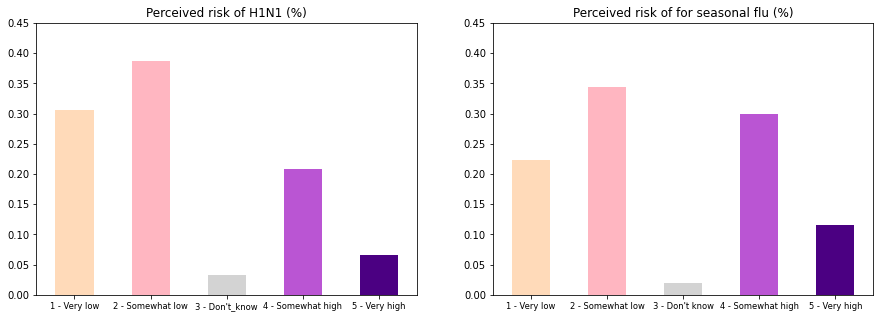

In [48]:
# Plotting the overall risk perception for H1N1 and for seasonal flu

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15,5))

df['opinion_h1n1_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax1, rot=0, color=['peachpuff', 'lightpink', 'lightgray', 'mediumorchid', 'indigo']
)
ax1.set_title('Perceived risk of H1N1 (%)')
ax1.set_xlabel('')
ax1.set_xticklabels(["1 - Very low", "2 - Somewhat low", "3 - Don't_know", "4 - Somewhat high",
                                 "5 - Very high"], fontsize='small')
ax1.set_ylim([0,0.45]) # setting the limits for the y-axis

df['opinion_seas_risk'].value_counts(normalize=True, sort=False).plot(kind='bar', ax=ax2, rot=0, color=['peachpuff', 'lightpink', 'lightgray', 'mediumorchid', 'indigo'])
ax2.set_title('Perceived risk of for seasonal flu (%)')
ax2.set_xlabel('')
ax2.set_xticklabels(["1 - Very low", "2 - Somewhat low", "3 - Don't know", "4 - Somewhat high",
                                  "5 - Very high"], fontsize='small')
ax2.set_ylim([0,0.45]) # setting the limits for the y-axis


fig.subplots_adjust(hspace=0.3)

plt.savefig('../images/risk_perception.jpg')
plt.show()


- Surprisingly, the risk for seasonal flu is estimated higher than the risk for H1N1. 
- Next step: investigate on the level of knowledge and the level of concern for H1N1.

/Users/julianeberek/neuefische/TheFluShot/.venv/lib/python3.8/site-packages/pandas/io/formats/format.py:1403: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



<AxesSubplot:xlabel='opinion_h1n1_risk', ylabel='count'>

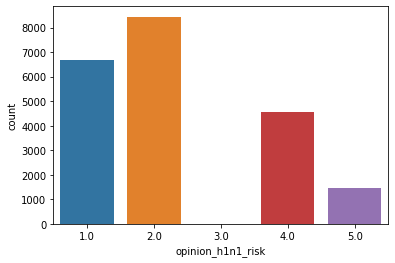

In [49]:
data_x = df.query('opinion_h1n1_risk != 3.0')
sns.countplot(x='opinion_h1n1_risk', data=data_x)

In [50]:
# Plotting concerns about H1N1 
# note that an image can only be printed once the kaleido package is installed: pip install -U kaleido

x_concern = df.h1n1_concern.value_counts(normalize=True)
x_concern_labels = ['Not at all concerned', 'Not very concerned', 'Somewhat concerned', 'Very concerned']

fig = px.pie(df, values=x_concern, names=x_concern_labels, title='Concerns about H1N1', template='ggplot2', hole=0.3, width=600, height=500)
fig.show()
fig.write_image("../images/concerns_h1n1.png")

- About every 10th is very concerned about H1N1, 16% are somewhat concerned.
- The vast majority is not at all or not very concerned. 
- This is in line with the findings for risk perception where we could see that risk awareness for H1N1 falls behind with regard to seasonal flu. 

In [51]:
# Plotting knowledge about H1N1 
x_knowledge = df.h1n1_knowledge.value_counts(normalize=True)
x_knowledge_labels = ['No knowledge', 'A little knowledge', 'A lot of knowledge']

fig = px.pie(df, values=x_knowledge, names=x_knowledge_labels, title='Knowledge about H1N1', template='ggplot2', hole=0.3, width=600, height=500)
fig.show()
fig.write_image("../images/knowledge_h1n1.png")


- The majority of people states to have no knowledge about the H1N1 flu variant. 
- 37% have a little knowledge.
- Overall, there seems to be little literacy about this new pandemic disease. 

In [69]:
df_age = df.age_group.value_counts()
df_age

65+ Years        5393
55 - 64 Years    4655
45 - 54 Years    4390
18 - 34 Years    4277
35 - 44 Years    3138
Name: age_group, dtype: int64

In [53]:
# we will also change the age_group column into categorical 
df['age_group'] = pd.Categorical(df['age_group'], ordered=True)

### Trying to create more plots with plotly

In [86]:
#values_h1n1 = df.h1n1_vaccine.value_counts(normalize=True)
#values_seasonal = df.seasonal_vaccine.value_counts(normalize=True)
#categories = pd.melt(df, value_vars=['h1n1_vaccine', 'seasonal_vaccine'])
#data = categories
#values_h1n1 = categories[categories.variable == 'h1n1_vaccine']
#values_seasonal = categories[categories.variable == 'seasonal_vaccine']

fig_age = px.bar(df_age, x=['65+ years', '55 - 64 Years', '45 - 54 Years', '18 - 34 Years', '35 - 44 Years'], y='age_group',
            barmode='group',
            height=400)
fig_age.update_layout(title='Age distribution',
                   xaxis_title='Age group',
                   yaxis_title='Number of respondents')
fig_age.update_xaxes(categoryorder='category descending')
fig_age.show()

In [82]:
values_h1n1

,variable,value
0,h1n1_vaccine,0
1,h1n1_vaccine,0
2,h1n1_vaccine,0
3,h1n1_vaccine,0
4,h1n1_vaccine,0
...,...,...
21848,h1n1_vaccine,0
21849,h1n1_vaccine,0
21850,h1n1_vaccine,0
21851,h1n1_vaccine,0


In [64]:
categories

,variable,value
0,h1n1_vaccine,0
1,h1n1_vaccine,0
2,h1n1_vaccine,0
3,h1n1_vaccine,0
4,h1n1_vaccine,0
...,...,...
43701,seasonal_vaccine,0
43702,seasonal_vaccine,0
43703,seasonal_vaccine,0
43704,seasonal_vaccine,1


In [84]:
fig = px.bar(categories, x="variable", y="value", color='value', title="Long-Form Input")
fig.show()

In [55]:
### Not needed because this does not help:

# Changing the labels for the columns opinion_seas_risk and opinion_h1n1_risk

labels_risk = {"opinion_h1n1_risk": {1.0: "1 - Very low", 2.0: "2 - Somewhat low", 3.0: "3 - Don't know", 4.0: "4 - Somewhat high",
                                  5.0: "5 - Very high"},
            "opinion_seas_risk": {1.0: "1 - Very low", 2.0: "2 - Somewhat low", 3.0: "3 - Don't know", 4.0: "4 - Somewhat high",
                                  5.0: "5 - Very high"},
                                  }

### Additional visualisations

In [56]:
df_report = pd.read_csv('/Users/julianeberek/neuefische/TheFluShot/data/FluNetInteractiveReport.csv', skiprows=3)

In [57]:
df_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            75 non-null     object 
 1   WHOREGION          75 non-null     object 
 2   FLUREGION          75 non-null     object 
 3   Year               75 non-null     int64  
 4   Week               75 non-null     int64  
 5   SDATE              75 non-null     object 
 6   EDATE              75 non-null     object 
 7   SPEC_RECEIVED_NB   75 non-null     int64  
 8   SPEC_PROCESSED_NB  75 non-null     int64  
 9   AH1                75 non-null     int64  
 10  AH1N12009          61 non-null     float64
 11  AH3                75 non-null     int64  
 12  AH5                40 non-null     float64
 13  ANOTSUBTYPED       75 non-null     int64  
 14  INF_A              75 non-null     int64  
 15  BYAMAGATA          40 non-null     float64
 16  BVICTORIA          40 non-nu

In [58]:
df_report['formatted_date'] = df_report.Year * 1000 + df_report.Week * 10 + 0
df_report['date'] = pd.to_datetime(df_report['formatted_date'], format='%Y%W%w')
df_report.head()

,Country,WHOREGION,FLUREGION,Year,Week,SDATE,EDATE,SPEC_RECEIVED_NB,SPEC_PROCESSED_NB,AH1,AH1N12009,AH3,AH5,ANOTSUBTYPED,INF_A,BYAMAGATA,BVICTORIA,BNOTDETERMINED,INF_B,ALL_INF,ALL_INF2,TITLE,formatted_date,date
0,United States of America,Region of the Americas of WHO,North America,2009,1,2008-12-29,2009-01-04,6613,6613,111,NaN,19,NaN,177,307,NaN,NaN,50,50,357,NaN,Sporadic,2009010,2009-01-11
1,United States of America,Region of the Americas of WHO,North America,2009,2,2009-01-05,2009-01-11,6980,6980,163,NaN,27,NaN,300,490,NaN,NaN,78,78,568,NaN,Sporadic,2009020,2009-01-18
2,United States of America,Region of the Americas of WHO,North America,2009,3,2009-01-12,2009-01-18,7024,7024,195,NaN,22,NaN,421,638,NaN,NaN,104,104,742,NaN,Sporadic,2009030,2009-01-25
3,United States of America,Region of the Americas of WHO,North America,2009,4,2009-01-19,2009-01-25,7959,7959,353,NaN,46,NaN,666,1065,NaN,NaN,189,189,1254,NaN,Local Outbreak,2009040,2009-02-01
4,United States of America,Region of the Americas of WHO,North America,2009,5,2009-01-26,2009-02-01,9496,9496,555,NaN,78,NaN,940,1573,NaN,NaN,380,380,1953,NaN,Regional Outbreak,2009050,2009-02-08


In [59]:
# Plotting the weekly H1N1 cases 
fig = px.line(df_report, x="date", y="AH1N12009", title='H1N1 Confirmed Cases (weekly)')
fig.show()

In [60]:
# Plotting H1N1 cases against all influenza cases (all types A and B)

fig = go.Figure()
date = df_report['date']
h1n1 = df_report['AH1N12009']
all_a = df_report['INF_A']
all_inf = df_report['ALL_INF']

fig.add_trace(go.Scatter(x=date, y=h1n1,
                    mode='lines',
                    name='H1N1 cases'))
fig.add_trace(go.Scatter(x=date, y=all_a,
                    mode='lines+markers',
                    name='All type A influenza cases'))
fig.add_trace(go.Scatter(x=date, y=all_inf,
                    mode='lines', name='Total number influenza cases'))

fig.update_layout(title='H1N1 cases against all influenza cases 2009/2010',
                   xaxis_title='Month',
                   yaxis_title='Number of confirmed cases')
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()